## Tune Segmentation with traditional ImageOps

Since we are having huge discrepancies between the xrays we got and the ones that the NN is trained for, we try enhancing strategies to improve segmentation results.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from src.segmentation import segmentation
from src.segmentation.models import PretrainedUNet
import torch, torchvision
torch.manual_seed(42)
from pydicom import dcmread
from PIL import Image
from skimage.io import imread


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Torch device: ", device)

import os
import random
path = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/"
#path = "/Volumes/Samsung_T5/MA/manifest-1641816674790/testing/"
dcms = []
for subdir, dirs, files in os.walk(path):
    for file in files:
            if not file.startswith("._"):
                if file.endswith(".dcm"):
                    if "1.000000" in subdir:
                        dcms.append(os.path.join(subdir,file)) 

Torch device:  cpu


In [2]:
print(random.choice(dcms))


/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A860070/03-07-1901-NA-CHEST AP VIEWONLY-28599/1.000000-AP-63867/1-1.dcm


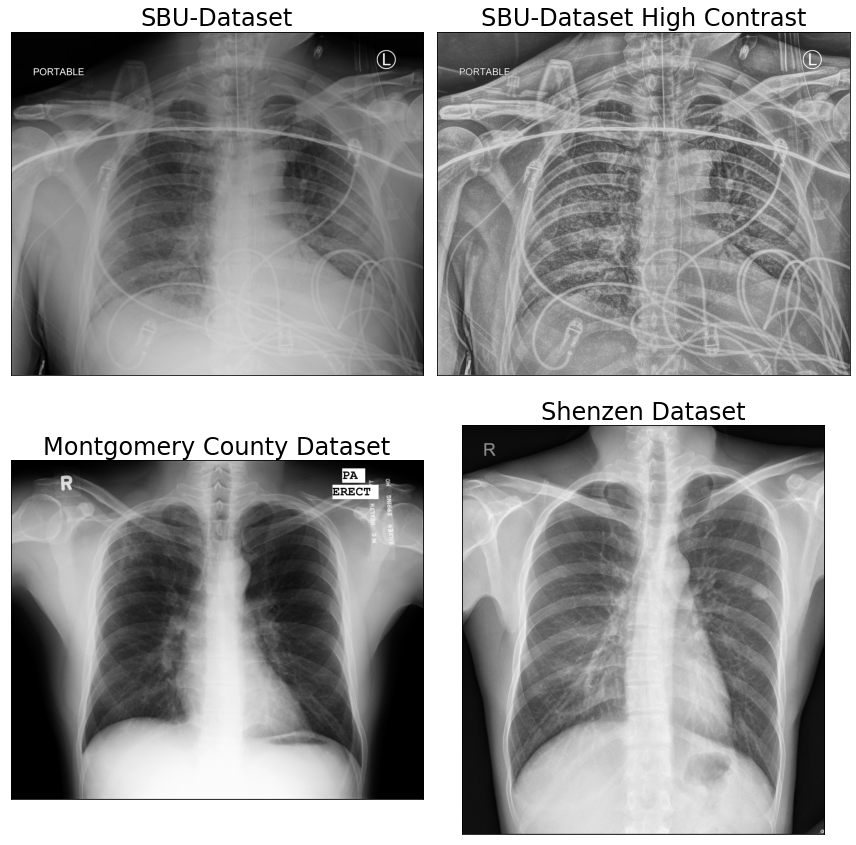

In [3]:
def plot_datasets_overv(preproc=None):
    fontsize=24
    fig, ax = plt.subplots(2, 2, figsize=(12,12))

    for i in range(2):
        for j in range(2):
            ax[i,j].set_xticks([]) 
            ax[i,j].set_yticks([]) 
        

    #fpath = random.choice(dcms)
    #print(fpath)
    fpaths = ["/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A099771/12-26-1900-NA-CHEST AP PORT-72677/1.000000-AP-02239/1-1.dcm",
               "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A099771/12-26-1900-NA-CHEST AP PORT-72677/2.000000-AP-22589/1-1.dcm"
               ]
    for i, fpath in enumerate(fpaths):
        dcm = dcmread(fpath)
        origin = dcm.pixel_array
        if preproc is not None:
            origin = preproc(origin) # return pic as in between [0,1]
            # print(np.min(origin), np.max(origin))
            origin = np.round(origin * 255) 
            origin = Image.fromarray(origin).convert("P")
        else:
            origin = np.round(origin/origin.max()*255)
            origin = Image.fromarray(origin).convert("P")

        ax[0,i].imshow(origin, cmap="gray")
    ax[0,0].set_title("SBU-Dataset", fontsize=fontsize)
    ax[0,1].set_title("SBU-Dataset High Contrast", fontsize=fontsize)
    img = imread("/Volumes/Samsung_T5/MA/dataset/images/MCUCXR_0350_1.png")
    ax[1,0].imshow(img, cmap="gray")
    ax[1,0].set_title("Montgomery County Dataset", fontsize=fontsize)

    img2 = imread("/Volumes/Samsung_T5/MA/dataset/images/CHNCXR_0518_1.png")
    ax[1,1].imshow(img2, cmap="gray")
    ax[1,1].set_title("Shenzen Dataset", fontsize=fontsize)

    fig.tight_layout()
    #fig.savefig("images/figures/xrays_dataset_comparison.png", dpi=300)
    fig.savefig("../thesis/figures/xrays_dataset_comparison-1.png")

plot_datasets_overv()

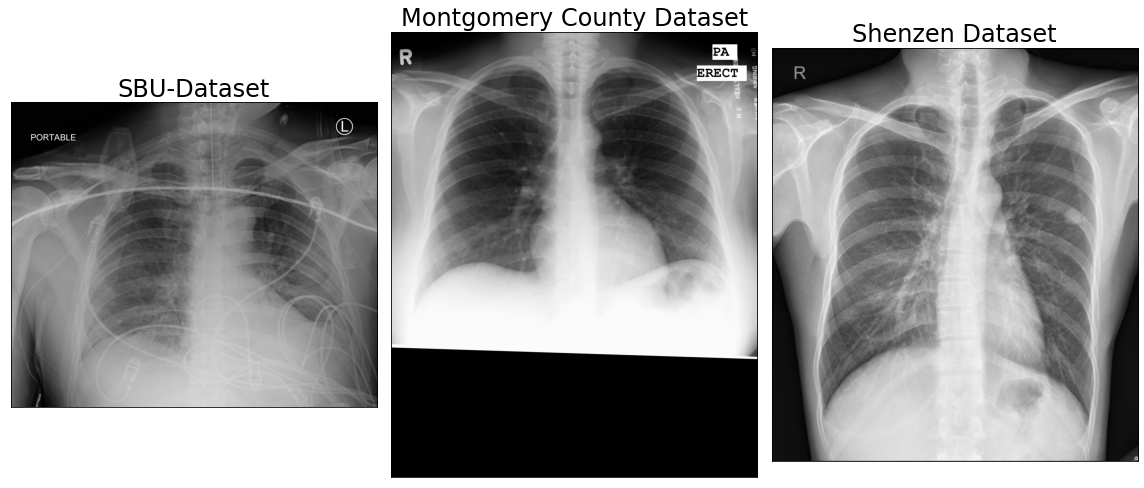

In [4]:
def plot_datasets(preproc=None):
    fontsize=24
    fig, ax = plt.subplots(1, 3, figsize=(16,8))

    for i in range(3):
        ax[i].set_xticks([]) 
        ax[i].set_yticks([]) 

    #fpath = random.choice(dcms)
    #print(fpath)
    fpath = "/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A099771/12-26-1900-NA-CHEST AP PORT-72677/1.000000-AP-02239/1-1.dcm"
    dcm = dcmread(fpath)
    origin = dcm.pixel_array
    if preproc is not None:
        origin = preproc(origin) # return pic as in between [0,1]
        # print(np.min(origin), np.max(origin))
        origin = np.round(origin * 255) 
        origin = Image.fromarray(origin).convert("P")
    else:
        origin = np.round(origin/origin.max()*255)
        origin = Image.fromarray(origin).convert("P")

    ax[0].imshow(origin, cmap="gray")
    ax[0].set_title("SBU-Dataset", fontsize=fontsize)
    img = imread("/Volumes/Samsung_T5/MA/dataset/images/MCUCXR_0021_0.png")
    ax[1].imshow(img, cmap="gray")
    ax[1].set_title("Montgomery County Dataset", fontsize=fontsize)

    img2 = imread("/Volumes/Samsung_T5/MA/dataset/images/CHNCXR_0518_1.png")
    ax[2].imshow(img2, cmap="gray")
    ax[2].set_title("Shenzen Dataset", fontsize=fontsize)

    fig.tight_layout()
    
plot_datasets()

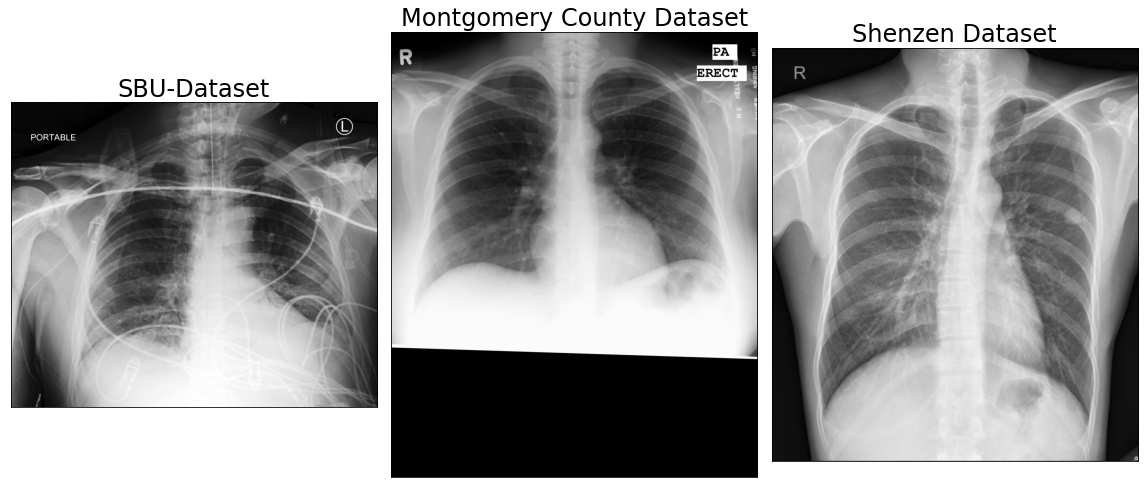

In [5]:
from skimage.filters import median
from skimage.exposure import equalize_hist
from skimage.morphology import disk, ball

def median_histeq(img):
    _img = img.copy()
    _img = median(_img,
     disk(3)
    )
    _img = equalize_hist(_img)
    return _img


plot_datasets(preproc=median_histeq)

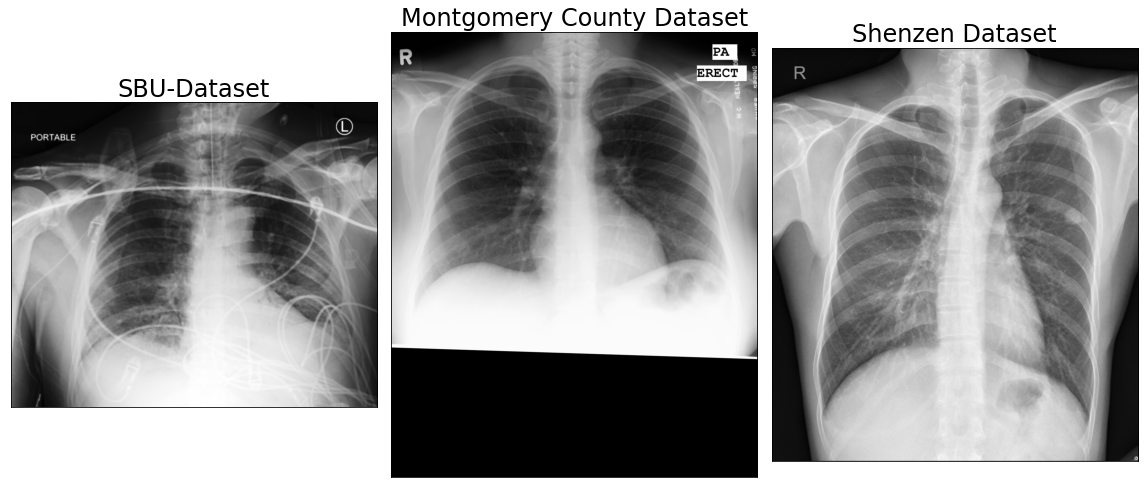

In [6]:
from skimage.filters import gaussian

def blur_histeq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=3.5)
    _img = equalize_hist(_img)
    return _img


plot_datasets(preproc=blur_histeq)

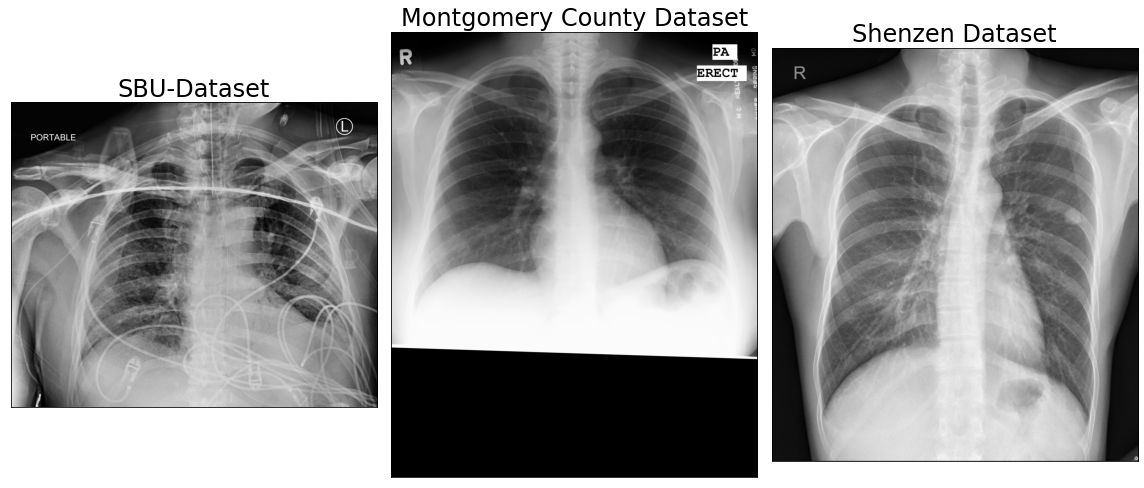

In [7]:
from skimage.exposure import equalize_adapthist

def adapthisteq(img):
    _img = img.copy()
    _img = equalize_adapthist(_img, clip_limit=0.01)
    return _img

plot_datasets(preproc=adapthisteq)

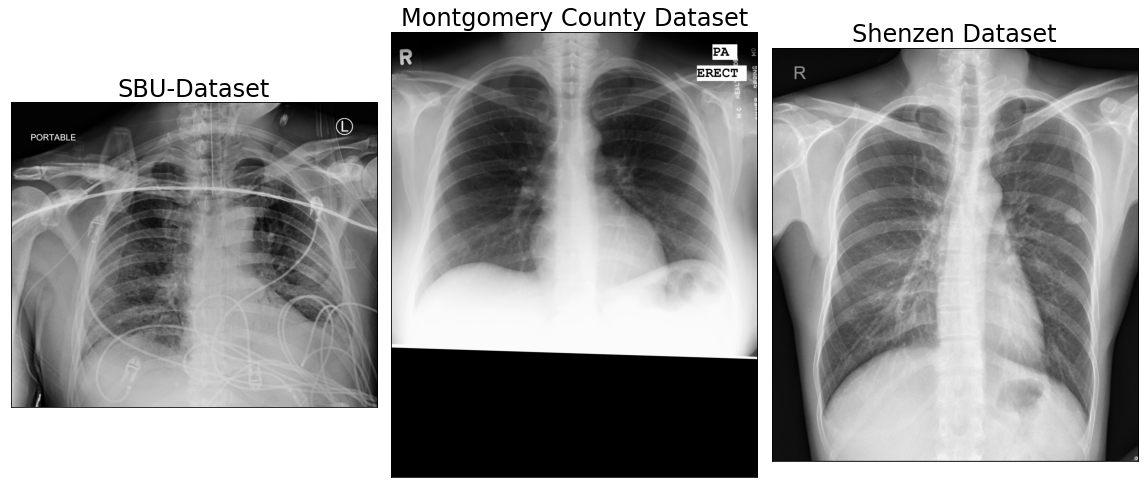

In [8]:
def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.0075)
    return _img


plot_datasets(preproc=blur_adapthisteq)

---
### Testing segmentation

In [9]:
## Prepare U-Net
unet = PretrainedUNet(
    in_channels=1,
    out_channels=2, 
    batch_norm=True, 
    upscale_mode="bilinear"
)

## Load pre-learnt
model_name = "unet-6v.pt"
unet.load_state_dict(torch.load(f"models/lung_seg/{model_name}", map_location=torch.device("cpu")))
unet.to(device)
print("") #omit load_state_dict output

#in_images, out_images = segmentation.process_dcim(batch, unet, device)



In [10]:
def infer_and_plot(fpath, model, plot=True, preproc=None):
    
    dcm = dcmread(fpath)
    origin = dcm.pixel_array

    if preproc is not None:
        origin = preproc(origin)
        origin = np.round(origin * 255)
        origin = Image.fromarray(origin).convert("P")
    else:
        origin = np.round(origin/origin.max() * 255) 
        origin = Image.fromarray(origin).convert("P")
    #print("input array: ", np.min(np.array(origin)), np.max(np.array(origin)))
    origin = torchvision.transforms.functional.resize(origin, (512, 512))
    origin = torchvision.transforms.functional.to_tensor(origin) - 0.5
    print("tensor: ", torch.min(origin), torch.max(origin))

    with torch.no_grad():
                origin = torch.stack([origin])
                origin = origin.to(device)
                out = model(origin)
                softmax = torch.nn.functional.log_softmax(out, dim=1)
                out = torch.argmax(softmax, dim=1)
                
                origin = origin[0].to("cpu")  # back to [0,1]
                out = out[0].to("cpu")

    img = torchvision.transforms.functional.to_pil_image(origin + 0.5).convert("RGB")
    mask =  torchvision.transforms.functional.to_pil_image(torch.cat([
        torch.zeros_like(origin),
        torch.stack([out.float()]),
        torch.zeros_like(origin)
    ]))

    if plot:    
        fig, ax = plt.subplots(1, 3,
            figsize=(14,7)
        )
        ax[0].imshow(img)
        ax[1].imshow(Image.blend(img, mask, 0.2))
        ax[2].imshow(mask)
    else:
        return Image.blend(img, mask, 0.2)

tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.4961) tensor(0.5000)
tensor:  tensor(-0.4922) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)


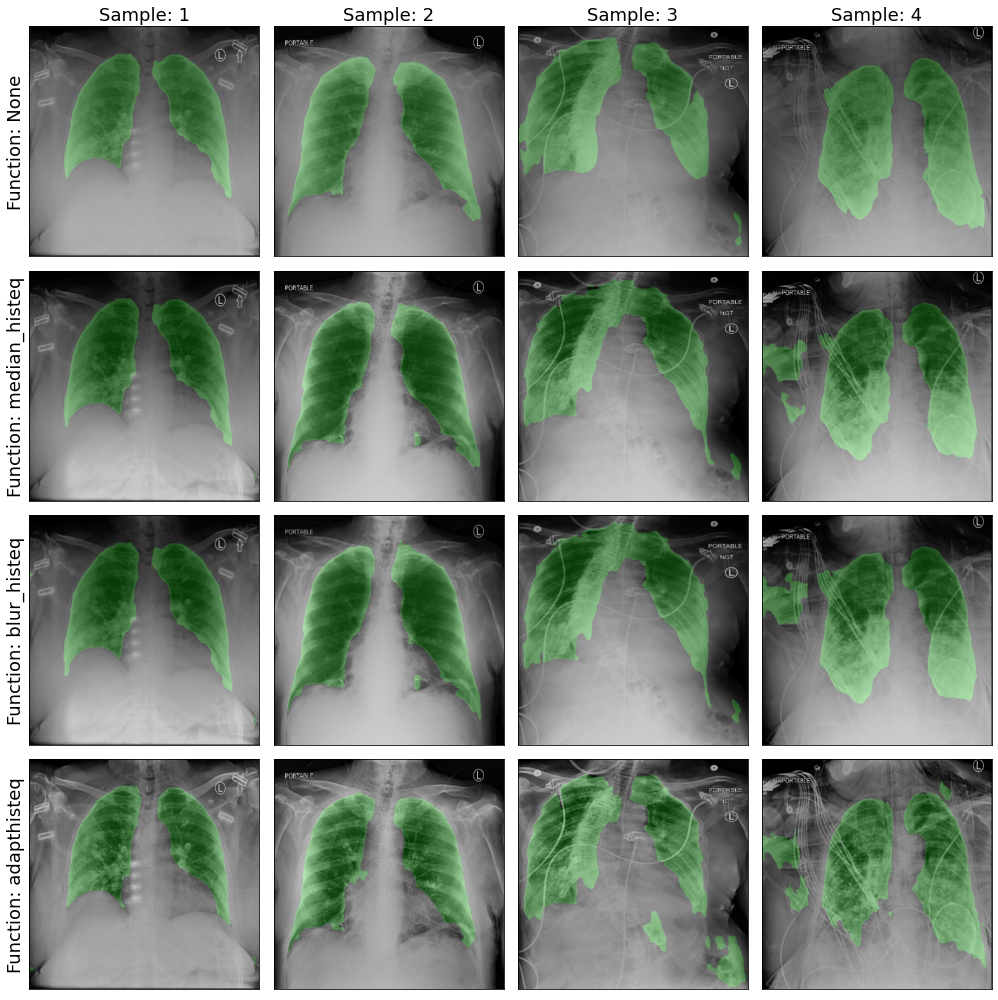

In [16]:
#sample = random.choices(dcms, k=4)
#print(sample)
#sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A438102/03-02-1901-NA-CHEST AP PORT-87926/1.000000-AP-29015/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A992004/01-04-1901-NA-CHEST AP PORT-39924/1.000000-AP-38186/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A943730/12-29-1900-NA-CHEST AP PORT-36400/1.000000-AP-43609/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A372249/12-25-1900-NA-CHEST AP PORT-36513/1.000000-AP-35787/1-1.dcm']
sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A724565/12-31-1900-NA-CHEST AP PORT-07182/1.000000-AP-10035/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A602816/12-28-1900-NA-CHEST AP PORT-66036/1.000000-AP-80374/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A851848/01-02-1901-NA-CHEST AP PORT-70361/1.000000-AP-97588/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A403529/01-21-1901-NA-CHEST AP PORT-99554/1.000000-AP-01788/1-1.dcm']

funcs = [None, median_histeq, blur_histeq, adapthisteq]

fig, ax = plt.subplots(len(funcs), len(sample), figsize=(14,14), facecolor=(1,1,1))
for i, f in enumerate(funcs):
    for j, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, unet, plot=False, preproc=f))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if i == 0:
            ax[i, j].set_title(f"Sample: {j+1}", fontsize=18)
        if j == 0:
            ax[i, j].set_ylabel(f"Function: {f.__name__ if f is not None else f}", fontsize=18)
#fig.text(0.5, 1.01, 'Sample:', va='center', fontsize=20)
#fig.text(-0.01, 0.5, 'Preprocessing Function', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/img_preprocessing_1.png")

In [17]:
from skimage.exposure import equalize_adapthist

def median_adapthisteq(img):
    _img = img.copy()
    _img = median(_img, disk(3))
    _img = equalize_adapthist(_img, clip_limit=0.002)
    return _img

def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.002)
    return _img


In [18]:
# sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A724565/12-31-1900-NA-CHEST AP PORT-07182/1.000000-AP-10035/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A602816/12-28-1900-NA-CHEST AP PORT-66036/1.000000-AP-80374/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A851848/01-02-1901-NA-CHEST AP PORT-70361/1.000000-AP-97588/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A403529/01-21-1901-NA-CHEST AP PORT-99554/1.000000-AP-01788/1-1.dcm']
# #sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A724565/12-31-1900-NA-CHEST AP PORT-07182/1.000000-AP-10035/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A602816/12-28-1900-NA-CHEST AP PORT-66036/1.000000-AP-80374/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A851848/01-02-1901-NA-CHEST AP PORT-70361/1.000000-AP-97588/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A403529/01-21-1901-NA-CHEST AP PORT-99554/1.000000-AP-01788/1-1.dcm']

# funcs = [None, median_histeq, adapthisteq, median_adapthisteq, blur_adapthisteq]

# fig, ax = plt.subplots(len(funcs), len(sample), figsize=(24,15), facecolor=(.18, .31, .31))
# for i, f in enumerate(funcs):
#     for j, s in enumerate(sample):
#         ax[i, j].imshow(infer_and_plot(s, unet, plot=False, preproc=f))
#         ax[i, j].set_xticks([]) 
#         ax[i, j].set_yticks([])
#         ax[i, j].set_title(f"Sample:{j+1} - Func:{f.__name__ if f is not None else f}")
# fig.tight_layout()

Increase clip limit to get rid of outliers in sample 2+3

In [19]:
from skimage.exposure import equalize_adapthist

def median_adapthisteq(img):
    _img = img.copy()
    _img = median(_img, disk(3))
    _img = equalize_adapthist(_img, clip_limit=0.0075)
    return _img

def blur_adapthisteq(img):
    _img = img.copy()
    _img = gaussian(_img, sigma=1)
    _img = equalize_adapthist(_img, clip_limit=0.0075)
    return _img

tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)
tensor:  tensor(-0.5000) tensor(0.5000)


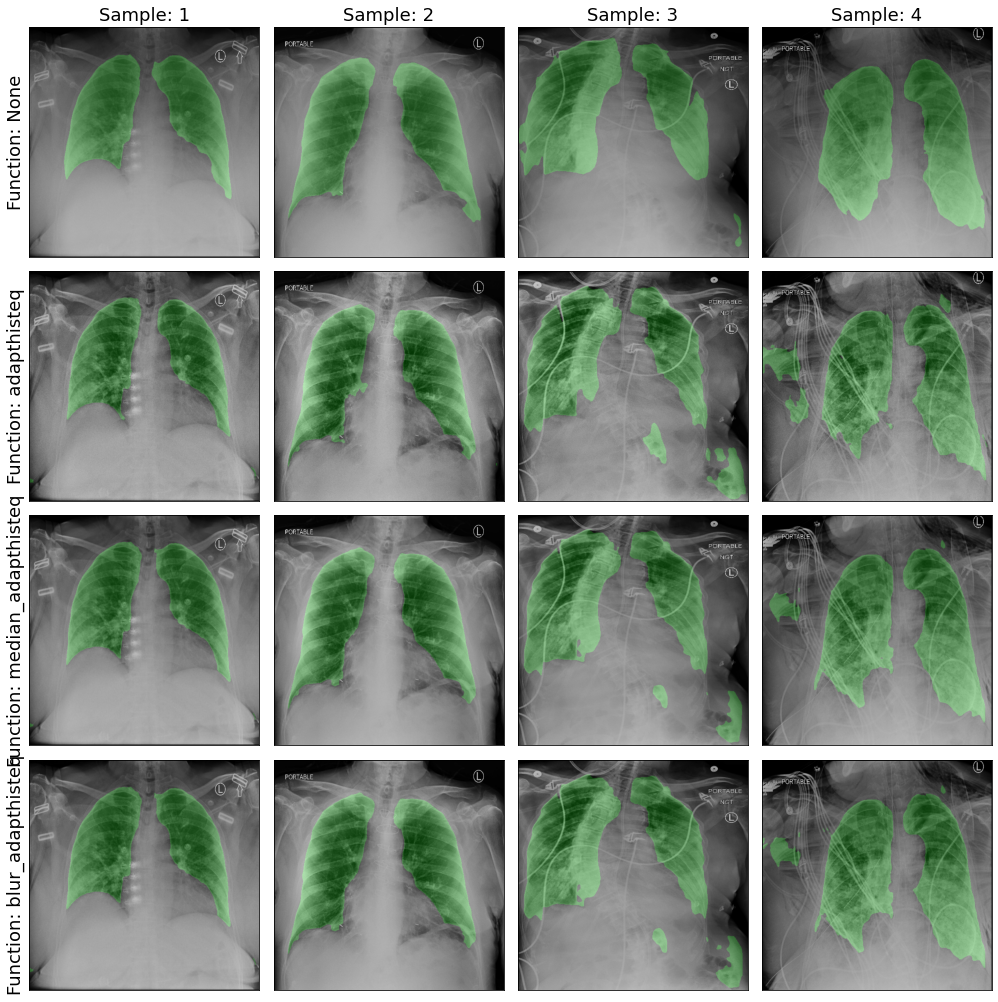

In [20]:
sample = ['/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A724565/12-31-1900-NA-CHEST AP PORT-07182/1.000000-AP-10035/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A602816/12-28-1900-NA-CHEST AP PORT-66036/1.000000-AP-80374/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A851848/01-02-1901-NA-CHEST AP PORT-70361/1.000000-AP-97588/1-1.dcm', '/Volumes/Samsung_T5/MA/manifest-1641816674790/subsample_thresh2/A403529/01-21-1901-NA-CHEST AP PORT-99554/1.000000-AP-01788/1-1.dcm']

funcs = [None, adapthisteq, median_adapthisteq, blur_adapthisteq]

fig, ax = plt.subplots(len(funcs), len(sample), figsize=(14,14), facecolor=(1., 1., 1.))
for i, f in enumerate(funcs):
    for j, s in enumerate(sample):
        ax[i, j].imshow(infer_and_plot(s, unet, plot=False, preproc=f))
        ax[i, j].set_xticks([]) 
        ax[i, j].set_yticks([])
        if i == 0:
            ax[i, j].set_title(f"Sample: {j+1}", fontsize=18)
        if j == 0:
            ax[i, j].set_ylabel(f"Function: {f.__name__ if f is not None else f}", fontsize=18)
#fig.text(0.5, 1.01, 'Sample:', va='center', fontsize=20)
#fig.text(-0.01, 0.5, 'Preprocessing Function', va='center', rotation='vertical', fontsize=20)
fig.tight_layout()
fig.savefig("../thesis/figures/impl/img_preprocessing_2.png")